# Disclaimers! - Skip this if you don't want the chaotic lore
From the AnimeDL-2M paper, the gold standard uses over **2 million** images, but here's why that's a pipe dream for me:
- I'm a second-year student, not a billionaire with an obsession for datacenters, so 2 million anime images? Yeah, my storage says *nope*.
- And downloading 2 million images from Danbooru? Let's crunch the numbers (based on Danbooru2021 report data):
  - Assume: 2 million images, 50/50 JPG-PNG split, 5% of PNGs are massive (say, 25MB each for high-res PNGs).
  - Average JPG size: ~400KB => 1 million JPGs = **400GB**.
  - Average PNG size: ~1MB, but with 50K high-res PNGs (25MB) + 950K regular PNGs (1MB):
    - 25MB × 50,000 + 1MB × 950,000 ≈ **2.25TB**.
  - Total: ~**2.65TB** of disk space (I don’t even have a 3TB drive).
  - Downloading 2.65TB at 10MB/s? That’s **~73 hours** of continuous downloading.
  - Oh, and that’s assuming no timeouts, no Danbooru bans, and my internet not throwing a tantrum.
- But wait, there’s more! Taking in my PC’s puny computational power:
  - Assume a 224x224 RGB JPEG image averages 150KB. For 2 million images, that would be **300GB** on disk.
  - However, in memory (float32 tensors):
    - 224 × 224 × 3 = 150,528 pixels/image.
    - 150,528 × 4 bytes (float32) ≈ 600KB/image.
    - 2,000,000 × 600KB ≈ **1.2TB of RAM** (how do I even get half of that?).
- So, mini-batch training it is. Now data loading from an HDD (~100MB/s) becomes the bottleneck.
  - Batch size: 64 (maxed out by my RTX 3060’s 12GB VRAM).
  - Steps per epoch: 2,000,000 / 64 ~ 31,250 steps.
  - For 30 epochs: 31,250 × 30 = **937,500 steps**.
  - One step on RTX 3060 takes ~250ms (*very* optimistic, based on my actual speed).
  - Total: 937,500 × 250ms = 234,375,000ms ~ **65 hours of raw GPU time**.
- Real world chaos:
  - +40% overhead for HDD data loading.
  - +10% for validation, logging, etc.
  - +10% for batch prep, shuffling, etc.
  - +15% for random lags, thermal throttling, and my PC’s existential crises.
  - Total: **~114 hours minimum**, assuming everything goes perfectly (it won’t).
  - Plus the trial-and-error? Every hyperparameter tweak or fix means another 114+ hours.
    - At that speed, just three retries would take more than 2 full weeks! I'd be lying in my deathbed before the model is finished...

#### In conclusion: Training a decent anime classifier from scratch in a few days as a second-year is outright *impossible*.
I’d need:
- A multi-GPU setup or a mountain of cloud compute credits.
- At least 3TB of blazing fast NVMe SSD storage (I don't even have money to eat).
- Endless trial and error time that I don't have.

# ---------------------------------- PHASE 1: BASELINE MODEL ----------------------------------

# 1. Prerequisites
A computer with at least 64GB RAM is very much appreciated

In [ ]:
!pip install -r requirements.txt

In [1]:
import os
import requests
import cv2
import json
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import asyncio
import aiohttp
import aiofiles
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from urllib.parse import urljoin
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from urllib.parse import urlparse
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# 2. Data collection
## 2.1 real anime pics <3 -> Labeled 0
initially only used 250, but i added another 750 pics for a total of 1k, then 1k was too little so now its 2850

seriously i've been traumatized by the things i downloaded even though i applied the filter "safe" and "1girl" and "solo"

too specific filters => not enough diversity (plus you gotta pay to include more criteria into your searches!)

too broad filters like this => spent 30 minutes deleting the nsfws

sources used: safebooru, gelbooru, danbooru, pixiv

In [35]:
def download_real_anime_from_danbooru():
    os.makedirs('data/real', exist_ok=True)

    # Danbooru API endpoint
    base_url = "https://danbooru.donmai.us/posts.json"

    downloaded = 0
    page = 1

    while downloaded < 750:
        # Search parameters
        params = {
            'tags': 'rating:safe 1girl solo', # tbh I don't know if it's even considered safe anymore
            'limit': 20,
            'page': page
        }

        try:
            response = requests.get(base_url, params=params, timeout=10)
            if response.status_code != 200:
                break

            posts = response.json()
            if not posts:
                break

            for post in posts:
                if downloaded >= 750:
                    break

                # Get image URL
                if 'file_url' in post and post['file_url']:
                    img_url = post['file_url']
                    if not img_url.startswith('http'):
                        img_url = 'https://danbooru.donmai.us' + img_url

                    # Download image
                    try:
                        img_response = requests.get(img_url, timeout=15)
                        if img_response.status_code == 200:
                            # Get file extension
                            ext = os.path.splitext(urlparse(img_url).path)[1]
                            if not ext:
                                ext = '.jpg'

                            filename = f'data/real/danbooru_{post["id"]}{ext}'
                            with open(filename, 'wb') as f:
                                f.write(img_response.content)

                            downloaded += 1
                            print(f"Downloaded real anime {downloaded}/750: {filename}")

                    except Exception as e:
                        print(f"Failed to download {img_url}: {e}")
                        continue

                # Rate limiting - be nice to Danbooru <3
                time.sleep(3)

        except Exception as e:
            print(f"API request failed: {e}")
            break

        page += 1
        time.sleep(3)  # rate limit between pages

    print(f"Downloaded {downloaded} real anime images from Danbooru")

download_real_anime_from_danbooru()

Downloaded real anime 1/750: data/real/danbooru_9418046.jpg
Downloaded real anime 2/750: data/real/danbooru_9418039.png
Downloaded real anime 3/750: data/real/danbooru_9418037.jpg
Downloaded real anime 4/750: data/real/danbooru_9418028.jpg
Downloaded real anime 5/750: data/real/danbooru_9418023.jpg
Downloaded real anime 6/750: data/real/danbooru_9418016.png
Downloaded real anime 7/750: data/real/danbooru_9418015.png
Downloaded real anime 8/750: data/real/danbooru_9418014.png
Downloaded real anime 9/750: data/real/danbooru_9418013.png
Downloaded real anime 10/750: data/real/danbooru_9418011.png
Downloaded real anime 11/750: data/real/danbooru_9418007.jpg
Downloaded real anime 12/750: data/real/danbooru_9417994.jpg
Downloaded real anime 13/750: data/real/danbooru_9417985.jpg
Downloaded real anime 14/750: data/real/danbooru_9417984.jpg
Downloaded real anime 15/750: data/real/danbooru_9417978.jpg
Downloaded real anime 16/750: data/real/danbooru_9417975.jpg
Downloaded real anime 17/750: dat

#### this is when i got ratelimited by Danbooru, then gelbooru and rule34 api were too much of a hassle so i just finished the rest with a prebuilt tool named Grabber

## 2.2 fake anime pics >:( -> Labeled 1
### canceled cuz i got blocked, i'll just download their already generated pics:
### 2850 pics, psi: 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2 (higher psi = more creativity = more instability)
#### (actually i downloaded 8000 pics, 1k per psi value, then performed some random deletion to crunch it down to 2850)

In [6]:
'''
def download_ai_anime():
    os.makedirs('data/ai_generated', exist_ok=True)
    downloaded = 0

    while downloaded < 250:
        import random
        seed = random.randint(0, 99999)

        # ThisAnimeDoesNotExist URL format
        url = f"https://thisanimedoesnotexist.ai/results/psi-0.5-0.6/seed{seed:05d}.png"

        try:
            response = requests.get(url, timeout=15)
            if response.status_code == 200:
                filename = f'data/ai_generated/ai_seed_{seed:05d}.png'
                with open(filename, 'wb') as f:
                    f.write(response.content)

                downloaded += 1
                print(f"Downloaded AI anime {downloaded}/250: seed {seed}")

                time.sleep(2)
            else:
                print(f"Failed to download seed {seed}, status: {response.status_code}")

        except Exception as e:
            print(f"Error downloading seed {seed}: {e}")
            continue

    print(f"Downloaded {downloaded} AI-generated anime images")

download_ai_anime()
'''

Failed to download seed 32104, status: 404
Failed to download seed 53994, status: 404
Failed to download seed 10691, status: 404
Failed to download seed 3371, status: 404
Failed to download seed 29138, status: 404
Failed to download seed 39375, status: 404
Failed to download seed 70290, status: 404
Failed to download seed 60007, status: 404
Failed to download seed 90954, status: 404
Failed to download seed 89393, status: 404
Failed to download seed 61292, status: 404
Failed to download seed 56889, status: 404


KeyboardInterrupt: 

# 3. Data preprocessing

In [19]:
def load_and_preprocess_data():
    def load_images_from_folder(folder, label):
        images = []
        labels = []

        files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]
        print(f"Loading {len(files)} images from {folder}...")

        for filename in files:
            img_path = os.path.join(folder, filename)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Preserve aspect ratio while resizing
                h, w = img.shape[:2]
                if h > w:
                    new_h, new_w = 224, int(224 * w / h)
                else:
                    new_h, new_w = int(224 * h / w), 224

                img = cv2.resize(img, (new_w, new_h))

                # Pad to 224x224
                pad_h = (224 - new_h) // 2
                pad_w = (224 - new_w) // 2
                img = cv2.copyMakeBorder(img, pad_h, 224-new_h-pad_h,
                                       pad_w, 224-new_w-pad_w,
                                       cv2.BORDER_CONSTANT, value=[0,0,0])

                # KEEP IN [0, 255] RANGE FOR MOBILENETV2
                img = img.astype('float32')
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue
        return images, labels

    print("=" * 50)
    print("LOADING AND PREPROCESSING DATA")
    print("=" * 50)

    # Load real anime <3 (label = 0)
    real_images, real_labels = load_images_from_folder('data/real', 0)

    # Load AI-generated slop (label = 1)
    ai_images, ai_labels = load_images_from_folder('data/ai_generated', 1)

    print("\nCombining datasets...")
    all_images = np.array(real_images + ai_images)
    all_labels = np.array(real_labels + ai_labels, dtype=np.float32)

    print(f"✅ Total images loaded: {len(all_images)}")
    print(f"✅ Real images: {len(real_images)}")
    print(f"✅ AI images: {len(ai_images)}")
    print(f"✅ Image value range: [{all_images.min():.1f}, {all_images.max():.1f}]")
    print("=" * 50)

    return all_images, all_labels

# 4. Build and train baseline model
remember to convert to f32, default is int64

🚀 Starting Anime Classifier Training
📂 STEP 1: Loading and preprocessing data...
LOADING AND PREPROCESSING DATA
Loading 2850 images from data/real...
Loading 2850 images from data/ai_generated...

Combining datasets...
✅ Total images loaded: 5700
✅ Real images: 2850
✅ AI images: 2850
✅ Image value range: [0.0, 255.0]
📊 STEP 2: Splitting data...
✅ Training samples: 3648
✅ Validation samples: 912
✅ Test samples: 1140
⚖️  STEP 4: Computing class weights...
✅ Class weights: {0: 1.0, 1: 1.0}
🏗️  STEP 5: Creating model...
✅ Model created successfully!
🎯 STEP 6: Starting progressive training...

STAGE 1: Training Classification Head
Frozen 156 layers, training classification head only
Starting Stage 1 training (10 epochs)...


C:\Users\Admin\anime_ai_detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 89s 728ms/step - accuracy: 0.7727 - loss: 0.4595 - precision: 0.7695 - recall: 0.7551 - val_accuracy: 0.9386 - val_loss: 0.1763 - val_precision: 0.9505 - val_recall: 0.9254
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 78s 685ms/step - accuracy: 0.9227 - loss: 0.1931 - precision: 0.9145 - recall: 0.9316 - val_accuracy: 0.9331 - val_loss: 0.1660 - val_precision: 0.9691 - val_recall: 0.8947
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 688ms/step - accuracy: 0.9377 - loss: 0.1650 - precision: 0.9277 - recall: 0.9471 - val_accuracy: 0.9331 - val_loss: 0.1761 - val_precision: 0.9805 - val_recall: 0.8838
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 689ms/step - accuracy: 0.9301 - loss: 0.1770 - precision: 0.9302 - recall: 0.9297 - val_accuracy: 0.9419 - val_loss: 0.1341 - val_precision: 0.9549 - val_recall: 0.9276
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 692ms/step - accuracy: 0.9339 - loss: 0.1631 - precision: 0.9285 - recall: 0.9441 - val_accuracy: 0.9397

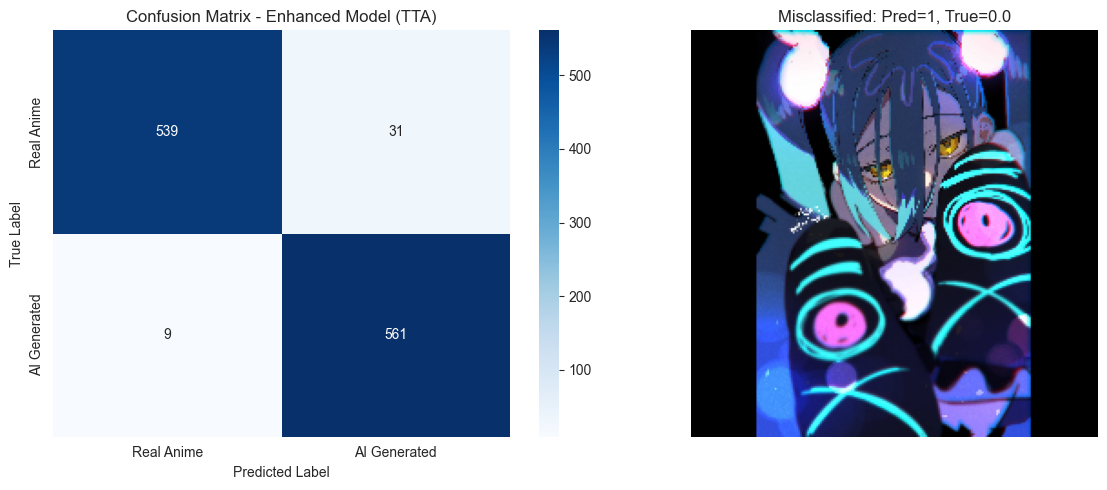

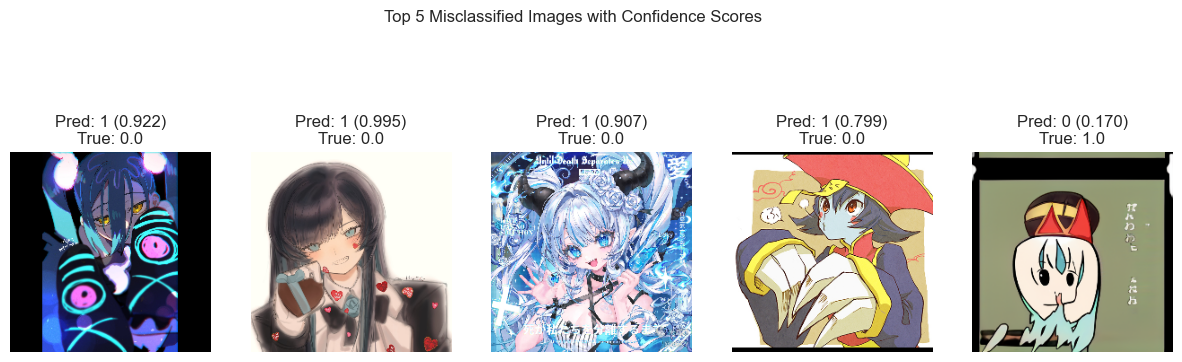

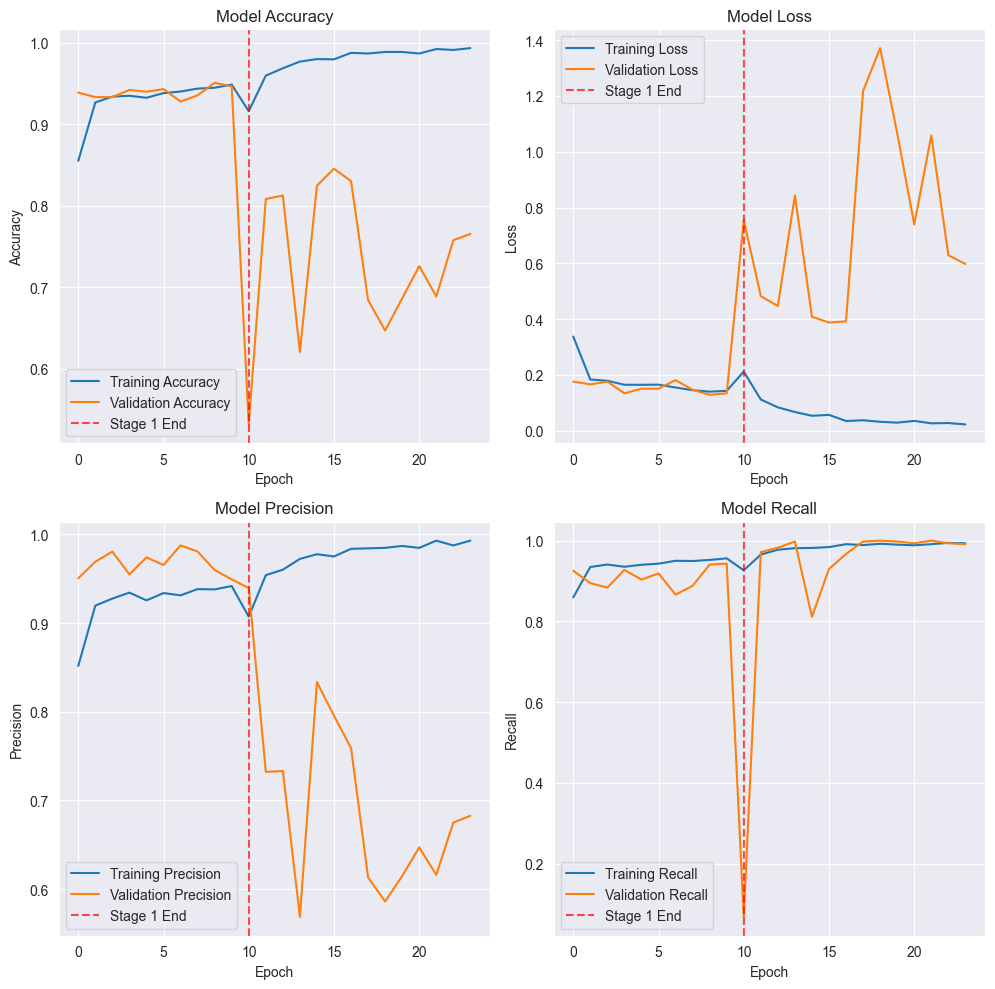

Enhanced model saved to models/enhanced_model.h5
Training history saved to models/enhanced_history.pkl
Enhanced results saved to models/enhanced_results.pkl

=== FINAL SUMMARY ===
Improvement over baseline:
Accuracy: 0.9596 (Target: >0.90)
TTA Accuracy: 0.9649
F1-Score: 0.5005
TTA F1-Score: 0.9656
Misclassified: 40/1140 samples


In [28]:
print("🚀 Starting Anime Classifier Training")
print("=" * 50)

def f1_score_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * precision * recall / (precision + recall + K.epsilon())

def get_class_weights(y_train_final):
    classes = np.unique(y_train_final)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train_final)
    class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, class_weights)}
    return class_weight_dict

def create_enhanced_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Initially freeze more layers for stable training
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Enhanced classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

def train_stage1(model, X_train_final, y_train_final, X_val, y_val, class_weight_dict):
    print("\n" + "=" * 50)
    print("STAGE 1: Training Classification Head")
    print("=" * 50)

    frozen_count = 0
    for layer in model.layers[:-6]:
        layer.trainable = False
        frozen_count += 1

    print(f"Frozen {frozen_count} layers, training classification head only")

    datagen_stage1 = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    print("Starting Stage 1 training (10 epochs)...")
    history1 = model.fit(
        datagen_stage1.flow(X_train_final, y_train_final, batch_size=32),
        steps_per_epoch=len(X_train_final) // 32,
        epochs=10,
        validation_data=(tf.keras.applications.mobilenet_v2.preprocess_input(X_val), y_val),
        class_weight=class_weight_dict,
        verbose=1
    )
    print("✅ Stage 1 completed!")
    return history1

def train_stage2(model, X_train_final, y_train_final, X_val, y_val, class_weight_dict):
    print("\n" + "=" * 50)
    print("🚀 STAGE 2: Fine-tuning with Enhanced Augmentation")
    print("=" * 50)

    unfrozen_count = 0
    for layer in model.layers[-30:]:
        layer.trainable = True
        unfrozen_count += 1

    print(f"Unfrozen {unfrozen_count} layers for fine-tuning")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    print("Recompiled model with lower learning rate (5e-5)")

    datagen_stage2 = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=[0.8, 1.2],
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.1,
        fill_mode='reflect',
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
    ]

    print("Starting Stage 2 training (up to 25 epochs w/ early stopping)...")
    print("Using augmentation")

    history2 = model.fit(
        datagen_stage2.flow(X_train_final, y_train_final, batch_size=64),
        steps_per_epoch=len(X_train_final) // 64,
        epochs=25,
        validation_data=(tf.keras.applications.mobilenet_v2.preprocess_input(X_val), y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    print("✅ Stage 2 completed!")
    return history2

def predict_with_tta(model, X_test, n_augmentations=5):
    print(f"\n Performing Test Time Augmentation ({n_augmentations+1} predictions)...")
    predictions = []

    print("  Computing base predictions...")
    X_test_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(X_test.copy())
    pred = model.predict(X_test_preprocessed, verbose=1)
    predictions.append(pred)

    # Augmented predictions
    datagen_tta = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    print(f"   Computing {n_augmentations} augmented predictions...")
    for i in range(n_augmentations):
        print(f"    Augmentation {i+1}/{n_augmentations}")
        X_aug = next(datagen_tta.flow(X_test, batch_size=len(X_test), shuffle=False))
        pred_aug = model.predict(X_aug, verbose=0)
        predictions.append(pred_aug)

    print("  Averaging predictions...")
    final_pred = np.mean(predictions, axis=0)
    print("✅ TTA completed!")
    return final_pred

# Load and preprocess data
print("📂 STEP 1: Loading and preprocessing data...")
X, y = load_and_preprocess_data()

print("📊 STEP 2: Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"✅ Training samples: {len(X_train_final)}")
print(f"✅ Validation samples: {len(X_val)}")
print(f"✅ Test samples: {len(X_test)}")

print("⚖️  STEP 4: Computing class weights...")
class_weight_dict = get_class_weights(y_train_final)
print(f"✅ Class weights: {class_weight_dict}")

print("🏗️  STEP 5: Creating model...")
model = create_enhanced_model()
print("✅ Model created successfully!")

print("🎯 STEP 6: Starting progressive training...")
history1 = train_stage1(model, X_train_final, y_train_final, X_val, y_val, class_weight_dict)
history2 = train_stage2(model, X_train_final, y_train_final, X_val, y_val, class_weight_dict)

combined_history = {}
for key in history1.history.keys():
    combined_history[key] = history1.history[key] + history2.history[key]

print("\n" + "=" * 50)
print("📊 FINAL EVALUATION")
print("=" * 50)

# Evaluate on test set with TTA
print("🔮 Evaluating with Test Time Augmentation...")
y_pred_tta = predict_with_tta(model, X_test, n_augmentations=5)
y_pred_binary_tta = (y_pred_tta > 0.5).astype(int).flatten()

print("📈 Computing standard evaluation metrics...")
X_test_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(X_test.copy())
test_results = model.evaluate(X_test_preprocessed, y_test, verbose=1)
test_loss, test_accuracy, test_precision, test_recall = test_results

# Calculate F1-score using sklearn (cuz Keras SUCKS!)
# "F1-score cannot be meaningfully used as a metric in keras neural network models, because keras will call F1-score at each batch step at validation, which results in too small values"
y_pred_standard = model.predict(X_test_preprocessed, verbose=0)
y_pred_binary_standard = (y_pred_standard > 0.5).astype(int).flatten()
standard_f1 = f1_score(y_test, y_pred_binary_standard, zero_division=0)

# TTA evaluation
tta_accuracy = np.mean(y_pred_binary_tta == y_test)
tta_f1 = f1_score(y_test, y_pred_binary_tta, zero_division=0)

print(f"\n🎉 RESULTS SUMMARY")
print("=" * 30)
print(f"🎯 Standard Accuracy: {test_accuracy:.4f}")
print(f"🚀 TTA Accuracy: {tta_accuracy:.4f}")
print(f"🎯 F1 Score: {standard_f1:.4f}")
print(f"🚀 TTA F1 Score: {tta_f1:.4f}")
print("=" * 30)

# Confusion matrix for TTA results
cm_tta = confusion_matrix(y_test, y_pred_binary_tta)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real Anime', 'AI Generated'],
            yticklabels=['Real Anime', 'AI Generated'])
plt.title('Confusion Matrix - Enhanced Model (TTA)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Classification report
print("\n=== CLASSIFICATION REPORT (TTA) ===")
print(classification_report(y_test, y_pred_binary_tta,
                          target_names=['Real Anime', 'AI Generated'],
                          zero_division=0))

# Error analysis: Plot misclassified images
misclassified_idx = np.where(y_pred_binary_tta != y_test)[0]
plt.subplot(1, 2, 2)
if len(misclassified_idx) > 0:
    sample_idx = misclassified_idx[0]
    # Normalize to [0,1] for display
    display_img = X_test[sample_idx] / 255.0
    plt.imshow(display_img)
    plt.title(f"Misclassified: Pred={y_pred_binary_tta[sample_idx]}, True={y_test[sample_idx]}")
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No misclassifications!', ha='center', va='center', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Plot detailed misclassified images
if len(misclassified_idx) > 0:
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_idx[:5]):
        plt.subplot(1, 5, i+1)
        # FIX: Normalize to [0,1] for display
        display_img = X_test[idx] / 255.0
        plt.imshow(display_img)
        confidence = y_pred_tta[idx][0]
        plt.title(f"Pred: {y_pred_binary_tta[idx]} ({confidence:.3f})\nTrue: {y_test[idx]}")
        plt.axis('off')
    plt.suptitle('Top 5 Misclassified Images with Confidence Scores')
    plt.show()

# Plot training history
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(combined_history['accuracy'], label='Training Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=len(history1.history['accuracy']), color='r', linestyle='--', alpha=0.7, label='Stage 1 End')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.axvline(x=len(history1.history['loss']), color='r', linestyle='--', alpha=0.7, label='Stage 1 End')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(combined_history['precision'], label='Training Precision')
plt.plot(combined_history['val_precision'], label='Validation Precision')
plt.axvline(x=len(history1.history['precision']), color='r', linestyle='--', alpha=0.7, label='Stage 1 End')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(combined_history['recall'], label='Training Recall')
plt.plot(combined_history['val_recall'], label='Validation Recall')
plt.axvline(x=len(history1.history['recall']), color='r', linestyle='--', alpha=0.7, label='Stage 1 End')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.tight_layout()
plt.show()

# Save model and results
os.makedirs('models', exist_ok=True)
model.save('models/enhanced_model.h5')
print("Enhanced model saved to models/enhanced_model.h5")

with open('models/enhanced_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)
print("Training history saved to models/enhanced_history.pkl")

# Save comprehensive results
enhanced_results = {
    'standard_accuracy': test_accuracy,
    'tta_accuracy': tta_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'standard_f1_score': standard_f1,
    'tta_f1_score': tta_f1,
    'confusion_matrix_tta': cm_tta,
    'training_history': combined_history,
    'misclassified_count': len(misclassified_idx),
    'total_test_samples': len(y_test)
}

with open('models/enhanced_results.pkl', 'wb') as f:
    pickle.dump(enhanced_results, f)
print("Enhanced results saved to models/enhanced_results.pkl")

print(f"\n=== FINAL SUMMARY ===")
print(f"Improvement over baseline:")
print(f"Accuracy: {test_accuracy:.4f} (Target: >0.90)")
print(f"TTA Accuracy: {tta_accuracy:.4f}")
print(f"F1-Score: {standard_f1:.4f}")
print(f"TTA F1-Score: {tta_f1:.4f}")
print(f"Misclassified: {len(misclassified_idx)}/{len(y_test)} samples")

fyi: the old f1 score was calculated batch-by-batch during training (which is incorrect) so...

don't mind the faulty Keras f1-score calc in the final summary, i forgot to switch ;P

# that was good! but not good enough - so let's add sth to spice it up
## ---------------------------------- FINISHED PHASE 1: BASELINE MODEL ----------------------------------
### -> Check the second notebook for the next phase

```this cell intentionally left blank```